[2019-10-15 15:00:00.000000] ERROR: user_log: order_number8
[2019-10-16 15:00:00.000000] ERROR: user_log: order_number8
[2019-10-17 15:00:00.000000] ERROR: user_log: order_number8
[2019-10-18 15:00:00.000000] ERROR: user_log: order_number8
[2019-10-21 15:00:00.000000] ERROR: user_log: order_number8
[2019-10-22 15:00:00.000000] ERROR: user_log: order_number8
[2019-10-23 15:00:00.000000] ERROR: user_log: order_number8
[2019-10-24 15:00:00.000000] ERROR: user_log: order_number8
[2019-10-25 15:00:00.000000] ERROR: user_log: order_number8
[2019-10-28 15:00:00.000000] ERROR: user_log: order_number8
[2019-10-29 15:00:00.000000] ERROR: user_log: order_number8
[2019-10-30 15:00:00.000000] ERROR: user_log: order_number8
[2019-10-31 15:00:00.000000] ERROR: user_log: order_number8
[2019-11-01 00:00:00.000000] INFO: user_log: 300970.XSHEis out of date...
[2019-11-01 00:00:00.000000] INFO: user_log: 300972.XSHEis out of date...
[2019-11-01 00:00:00.000000] INFO: user_log:             000998.XSHE  00

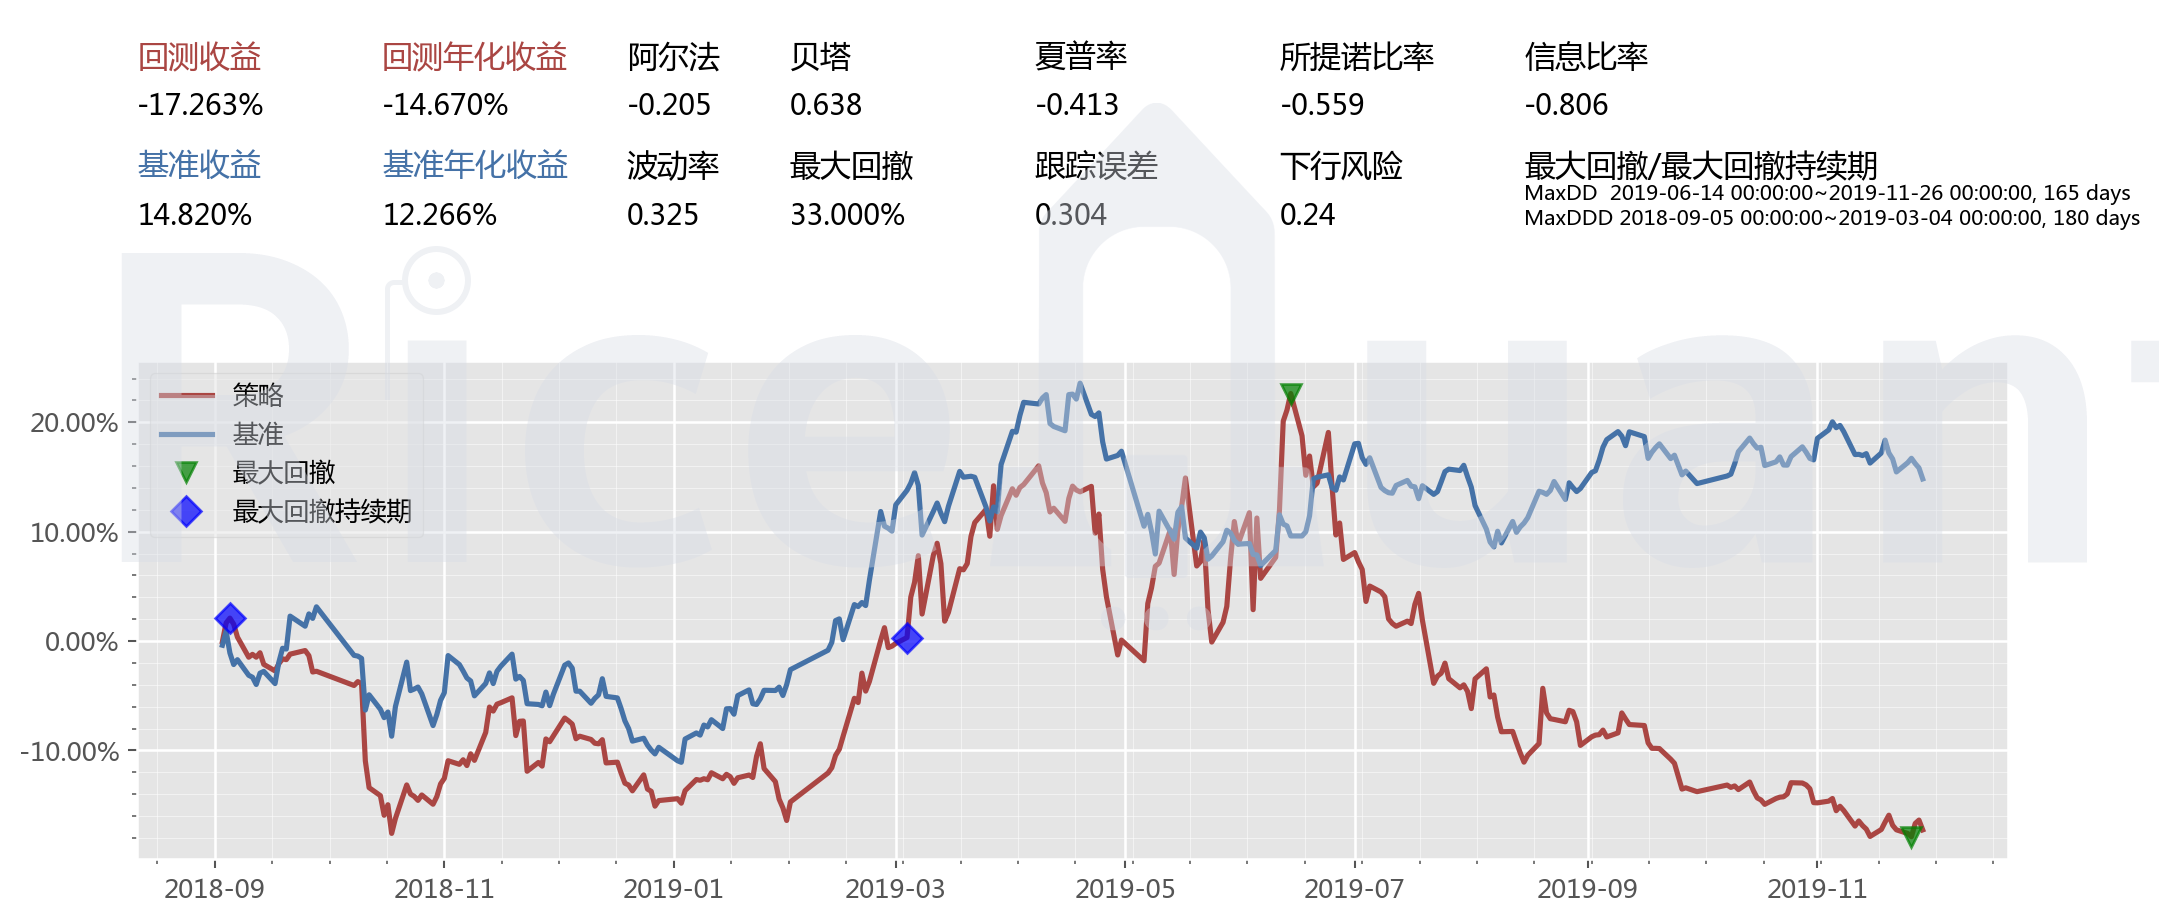

In [6]:
# 可以自己import我们平台支持的第三方python模块，比如pandas、numpy等。
from rqalpha.api import *
from rqalpha import run_func
import statsmodels.api as sm
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
config = {
  "base": {
    "start_date": "2018-09-01",
    "end_date": "2019-12-01",
    "frequency": "1d",
    "benchmark": "000300.XSHG",
    "plot": True,
    "accounts": {
        "stock": 1000000
    }
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    },
    "mongodb": {
        "enabled": False,
    }
  }
}
# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    # context内引入全局变量counter
    context.counter = 0
    context.pd_coe=pd.DataFrame
    context.pd_const=pd.DataFrame
    context.pd_std=pd.DataFrame
    context.stock_pos=[]
    #每月运行更新寻找协整股票对
    scheduler.run_monthly(find_stock_pairs, tradingday=1, time_rule='before_trading')
    #每月没有了结的仓位在更新协整股票时清仓
    scheduler.run_monthly(sink_stock, tradingday=1, time_rule=market_open(hour=0))
    
def find_cointegrated_pairs(dataframe):
    # 得到DataFrame长度
    n = dataframe.shape[1]
    #shape[1]表示列
    # 初始化p值矩阵
    pvalue_matrix = np.ones((n, n))
    # 抽取列的名称，这里列的名称存储的是股票的代码
    keys = dataframe.keys()
    # 初始化强协整组
    pairs = []
    #用于存放满足强协整关系的股票组合
    # 对于每一个i
    for i in range(n):
        # 对于大于i的j
        for j in range(i+1, n):
            # 获取相应的两只股票的价格Series
            stock1 = dataframe[keys[i]]
            stock2 = dataframe[keys[j]]
            # 分析它们的协整关系
            result = sm.tsa.stattools.coint(stock1, stock2)
            # 取出并记录p值
            pvalue = result[1]
            pvalue_matrix[i, j] = pvalue
            # 如果p值小于0.05
            if pvalue < 0.05:
                # 记录股票对和相应的p值
                pairs.append((keys[i], keys[j], pvalue))
    # 返回结果
    return pvalue_matrix, pairs
# before_trading此函数会在每天交易开始前被调用，当天只会被调用一次
def before_trading(context):
    context.counter=0
    pass

def find_stock_pairs(context,bar_dict):
    # 为了便于中间变量展示，获取10个交易日前信息，可以调整协整检验需要的股票数据时间区间
    selected_plate=industry('A01')
    stock_list = list(selected_plate)
    #选取所需要分析的板块，比如我们要看能源行业中具有协整关系的股票对，就为J66，可以更改为自己想研究的行业，选取网址在这https://www.ricequant.com/data/stock#Data—Stock-IndustrySectorConcept-industry
    #以选定时间的数据作为样本看这段时间的协整股票对。
    df = pd.DataFrame()
    timeDf = pd.DataFrame()
    newTimeDf = pd.DataFrame()
    for stock in stock_list:
        if datetime(2020, 1, 1,0,0)>instruments(stock).listed_date:
            try:
                price = history_bars(stock, 60, '1d', None, True, False, 'post')
                # logger.info(price_datetime)
                newTimeDf['datetime'] = pd.to_datetime(price['datetime'], format='%Y%m%d%H%M%S')
                # logger.info(pd.to_datetime(timeDf['datetime'].astype(str), format='%Y%m%d%H%M%S'))
                price_close = history_bars(stock, 60, '1d', 'close')
                df[stock]=pd.Series(price['close'], index=newTimeDf['datetime'])
            except ValueError:
                logger.info('value error')
        else:
            logger.info(stock + 'is out of date...')
    #logger.info(df)
    #获得强协整性股票对
    pvalues, pairs = find_cointegrated_pairs(df)
    l=len(pairs)
    
    mat=np.matrix
    if l>0:
        #说明选出的强协整对里有元素
        regression_pairs=pairs[0]
        dependent=[]  # 解释变量股票代码列表
        independent=[]  # 被解释变量股票代码列表
        for i in range(0,l):
            dependent.append(pairs[i][0])
        #往解释变量股票代码列表中填充股票元素
        for i in range(0,l):
            independent.append(pairs[i][1])
        #往被解释变量股票代码列表中填充股票元素
        dependent=sorted(set(dependent),key=dependent.index)
        #对解释变量代码进行排序，这里数据类型是集合，键值为解释变量索引
        independent=sorted(set(independent),key=independent.index)
        #对被解释变量进行排序，这里数据类型是集合，键值为被解释变量索引
        length=len(dependent)*len(independent)
        context.stock_long=np.zeros(length) 
        #分配股票仓位向量，以便之后判断买卖股票，这里存储股票多头头寸。
        context.stock_short=np.zeros(length)
        #分配股票仓位向量，以便之后判断买卖股票，这里存储股票空头头寸。
        #分配股票对的系数，常数，标准差DataFrame
        context.pd_coe=pd.DataFrame(index=list(independent),columns=dependent)
        context.pd_const=pd.DataFrame(index=list(independent),columns=dependent)
        context.pd_std=pd.DataFrame(index=list(independent),columns=dependent)
        #行索引是被解释变量股票列表，列键值是解释变量股票列表
        for k in range(0,l):
            #取得协整股票对的代码
            stock_sample1 = df[pairs[k][0]]
            stock_sample2 = df[pairs[k][1]]
            #对股票对进行ols回归
            y = stock_sample1
            x = stock_sample2
            X = sm.add_constant(x)
            result = (sm.OLS(y,X)).fit()
            #计算回归残差的标准差，也就是说diff是残差序列的标准差
            diff=np.std(y-result.params[1]*x)
            if len(result.params) >=2: 
                #判断语句确保ols回归有结果
                diff=np.std(y-result.params[1]*x)
                context.pd_coe[pairs[k][0]][pairs[k][1]]=result.params[1]
                #回归系数
                context.pd_const[pairs[k][0]][pairs[k][1]]=result.params[0]             #回归的常数项
            else:
                diff = 0.
            #将回归得到的数据赋值到DataFrame中
            context.pd_coe[pairs[k][0]][pairs[k][1]]=result.params[1]
            context.pd_const[pairs[k][0]][pairs[k][1]]=result.params[0]
            context.pd_std[pairs[k][0]][pairs[k][1]]=diff
def sink_stock(context,bar_dict):
    for stock in context.portfolio.positions:
        order_target_percent(stock,0)

def handle_bar(context, bar_dict):
    i=0 #计数器
    context.counter += 1
    #避开前10分钟
    if context.counter>=0:
        #取得股票对的代码
       dependent_stock=context.pd_coe.columns
       independent_stock=context.pd_coe.index
       order_number=len(context.pd_coe.values)
       logger.error("order_number{}".format(order_number))
        #确定股票对的数量，便于后面等权重分配下单资金
    for stock_de in dependent_stock:
            for stock_inde in independent_stock:
                if not np.isnan(context.pd_coe[stock_de][stock_inde]):
                    price_dep=history_bars(stock_de, 1, '1d','close')
                    price_inde=history_bars(stock_inde, 1, '1d', 'close')
                    #残差序列突破一倍标准差开仓
                    if price_dep-context.pd_const[stock_de][stock_inde]-context.pd_coe[stock_de][stock_inde]*price_inde>1*context.pd_std[stock_de][stock_inde]:
                        order_target_percent(stock_de,0)
                        order_target_percent(stock_inde,1/order_number)
                        #突破一倍标准差，卖出股票y，买入股票x。
                        context.stock_long[i]=1
                        context.stock_long[i]=1
                        #记录一个多头头寸
                        context.stock_short[i]=0
                        #记录一个空头头寸？
                    #残差序列跌破负一倍标准差开仓
                    if price_dep-context.pd_const[stock_de][stock_inde]-context.pd_coe[stock_de][stock_inde]*price_inde<-1*context.pd_std[stock_de][stock_inde]:
                        order_target_percent(stock_inde,0)
                        order_target_percent(stock_de,1/order_number)
                        context.stock_long[i]=0
                        context.stock_short[i]=1
                    i+=1           
def after_trading(context):
    pass
results = run_func(init=init, before_trading=before_trading, handle_bar=handle_bar, config=config)